
# 3. Datasets & Pre-Processing
This notebook documents the data understanding + cleaning pipeline for the CP322 Topic 3 project. Execute each section in order to regenerate the cleaned splits stored under `data/processed/`.



## 1. Dataset Overview
We work with two open datasets so that modeling techniques can be compared across domains.

- **House Prices (Kaggle)** – 1,460 residential properties from Ames, Iowa with 79 engineered features. Target is `SalePrice`. Mix of numeric (e.g., `GrLivArea`, `GarageArea`) and categorical (e.g., `Neighborhood`, `Exterior1st`) attributes with moderate missingness.
- **Energy Efficiency (UCI)** – 768 building simulations describing wall/roof glazing characteristics. Targets are `Y1` (heating load) and `Y2` (cooling load). Inputs are all numeric but on different scales, so normalization is necessary.

> Data dictionaries live in `data/raw/data_description.txt` (Kaggle) and within the UCI paper. Keep this cell updated if new fields are engineered.


In [ ]:
import json

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

plt.style.use('seaborn-v0_8')
sns.set_theme()

RAW_DIR = Path('../data/raw')
PROC_DIR = Path('../data/processed')
PROC_DIR.mkdir(parents=True, exist_ok=True)

HOUSE_RAW_PATH = RAW_DIR / 'train.csv'
HOUSE_TEST_PATH = RAW_DIR / 'test.csv'
ENERGY_RAW_PATH = RAW_DIR / 'ENB2012_data.xlsx'
RANDOM_STATE = 42

def describe_missing(df: pd.DataFrame, dataset_name: str, top_n: int = 15) -> pd.DataFrame:
    """Return sorted missing-value summary for quick inspection."""
    missing = df.isna().mean().sort_values(ascending=False)
    summary = missing[missing > 0].head(top_n).to_frame(name=f'{dataset_name}_pct_missing')
    return summary

print('House Prices rows:', pd.read_csv(HOUSE_RAW_PATH).shape)
print('Energy Efficiency rows:', pd.read_excel(ENERGY_RAW_PATH).shape)


Current working directory: /Users/ob/Downloads/CP322_Prj/cp322_project/notebooks
baselines.ipynb          data_preprocessing.ipynb
data                     improved_model.ipynb
House Prices rows: (1460, 81)
Energy Efficiency rows: (768, 10)



## 2. Exploratory Data Analysis
This section surfaces distributions and correlations that guide preprocessing decisions (log-transform targets, scale numeric columns, etc.).


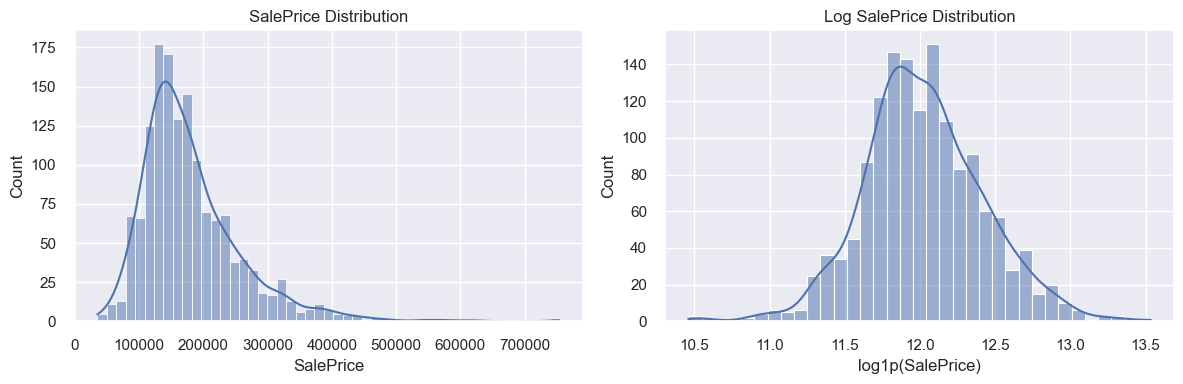

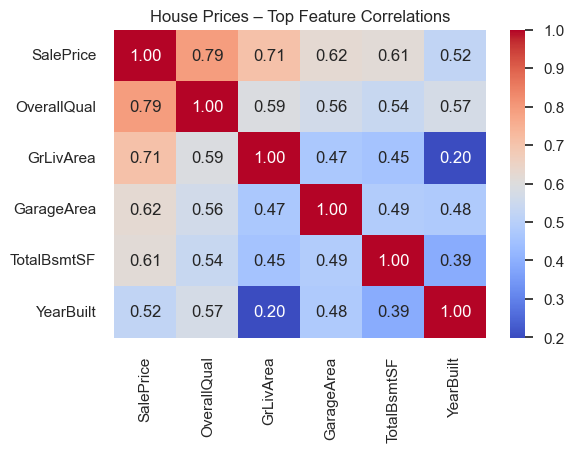

,house_pct_missing
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
MasVnrType,0.597260
FireplaceQu,0.472603
LotFrontage,0.177397
GarageYrBlt,0.055479
GarageCond,0.055479
GarageType,0.055479


In [2]:

# --- House Prices EDA -------------------------------------------------------
house_df = pd.read_csv(HOUSE_RAW_PATH)

house_target = 'SalePrice'

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(house_df[house_target], kde=True, ax=axes[0])
axes[0].set_title('SalePrice Distribution')
axes[0].set_xlabel('SalePrice')

sns.histplot(np.log1p(house_df[house_target]), kde=True, ax=axes[1])
axes[1].set_title('Log SalePrice Distribution')
axes[1].set_xlabel('log1p(SalePrice)')
plt.tight_layout()
plt.show()

corr_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearBuilt']
plt.figure(figsize=(6, 4))
sns.heatmap(house_df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('House Prices – Top Feature Correlations')
plt.show()

describe_missing(house_df, 'house').head(10)


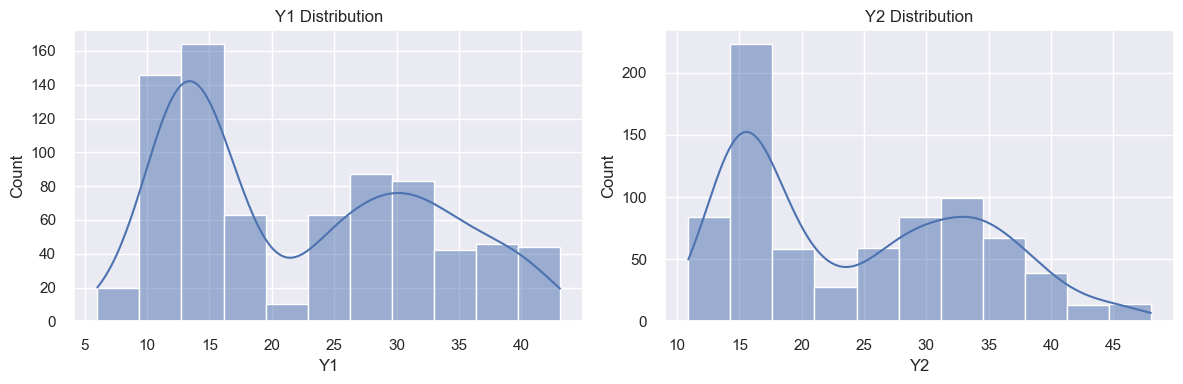

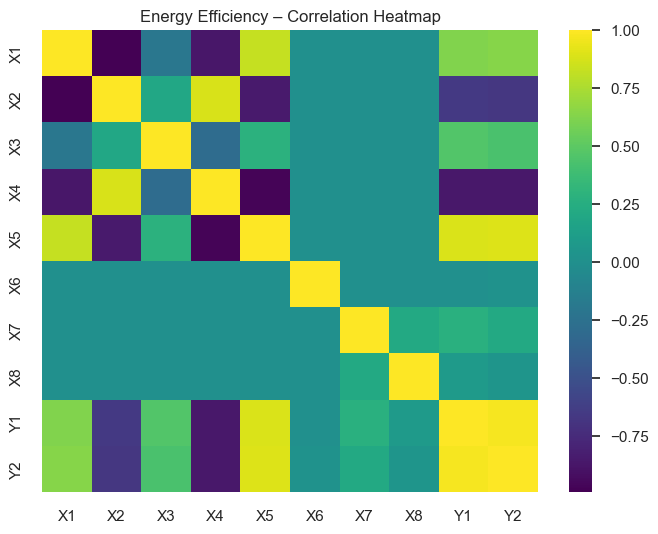

,energy_pct_missing


In [3]:

# --- Energy Efficiency EDA --------------------------------------------------
energy_df = pd.read_excel(ENERGY_RAW_PATH)
energy_df.columns = [c.strip() for c in energy_df.columns]
energy_targets = ['Y1', 'Y2']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for idx, target in enumerate(energy_targets):
    sns.histplot(energy_df[target], kde=True, ax=axes[idx])
    axes[idx].set_title(f'{target} Distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(energy_df.corr(), cmap='viridis', annot=False)
plt.title('Energy Efficiency – Correlation Heatmap')
plt.show()

describe_missing(energy_df, 'energy')



## 3. Preprocessing Pipelines
Steps applied to each dataset:

1. **Split** into train/validation/test with a fixed random seed (70/15/15 split achieved via two splits).
2. **Impute** missing numeric values with medians and categorical values with the most frequent category.
3. **Encode** categoricals using `OneHotEncoder(handle_unknown='ignore')`.
4. **Normalize** numeric columns using `StandardScaler`.
5. **Persist** processed splits and minimal metadata for reproducibility.


In [4]:

# --- Helper functions -------------------------------------------------------

def split_dataframe(df: pd.DataFrame, target_cols, test_size=0.15, val_size=0.15):
    y = df[target_cols]
    X = df.drop(columns=target_cols)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE)
    relative_val = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=relative_val, random_state=RANDOM_STATE)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


def build_house_preprocessor(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    if 'SalePrice' in num_cols:
        num_cols.remove('SalePrice')
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ])
    return preprocessor, num_cols, cat_cols


def build_energy_preprocessor(df: pd.DataFrame):
    num_cols = df.columns.tolist()
    for target in ['Y1', 'Y2']:
        if target in num_cols:
            num_cols.remove(target)
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, num_cols)
    ])
    return preprocessor, num_cols


def transform_to_frame(preprocessor, X, feature_prefix):
    array = preprocessor.transform(X)
    feature_names = preprocessor.get_feature_names_out()
    return pd.DataFrame(array, columns=[f'{feature_prefix}_{name}' for name in feature_names])



### 3.1 House Prices Pipeline


In [5]:

(H_train, h_y_train), (H_val, h_y_val), (H_test, h_y_test) = split_dataframe(
    house_df, target_cols=['SalePrice'])

house_preprocessor, house_num_cols, house_cat_cols = build_house_preprocessor(house_df)
house_preprocessor.fit(H_train)

H_train_proc = transform_to_frame(house_preprocessor, H_train, 'house')
H_val_proc = transform_to_frame(house_preprocessor, H_val, 'house')
H_test_proc = transform_to_frame(house_preprocessor, H_test, 'house')

for frame, target, split in [
    (H_train_proc, h_y_train, 'train'),
    (H_val_proc, h_y_val, 'val'),
    (H_test_proc, h_y_test, 'test'),
]:
    dataset = frame.copy()
    dataset['SalePrice'] = target.values
    out_path = PROC_DIR / f'house_prices_{split}.csv'
    dataset.to_csv(out_path, index=False)
    print(f'Saved {out_path}')

house_meta = {
    'numeric_columns': house_num_cols,
    'categorical_columns': house_cat_cols,
    'feature_count': H_train_proc.shape[1],
    'splits': {split: len(data) for split, data in {'train': H_train_proc, 'val': H_val_proc, 'test': H_test_proc}.items()}
}

with open(PROC_DIR / 'house_prices_metadata.json', 'w') as fh:
    json.dump(house_meta, fh, indent=2)

house_meta


Saved ../data/processed/house_prices_train.csv
Saved ../data/processed/house_prices_val.csv
Saved ../data/processed/house_prices_test.csv


{'numeric_columns': ['Id',
  'MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageYrBlt',
  'GarageCars',
  'GarageArea',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'PoolArea',
  'MiscVal',
  'MoSold',
  'YrSold'],
 'categorical_columns': ['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'RoofStyle',
  'RoofMatl',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'ExterQual',
  'ExterCond',
  'Foundation',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinTyp


### 3.2 Energy Efficiency Pipeline


In [6]:

(En_train, e_y_train), (En_val, e_y_val), (En_test, e_y_test) = split_dataframe(
    energy_df, target_cols=energy_targets)

energy_preprocessor, energy_num_cols = build_energy_preprocessor(energy_df)
energy_preprocessor.fit(En_train)

En_train_proc = transform_to_frame(energy_preprocessor, En_train, 'energy')
En_val_proc = transform_to_frame(energy_preprocessor, En_val, 'energy')
En_test_proc = transform_to_frame(energy_preprocessor, En_test, 'energy')

for frame, target, split in [
    (En_train_proc, e_y_train, 'train'),
    (En_val_proc, e_y_val, 'val'),
    (En_test_proc, e_y_test, 'test'),
]:
    dataset = frame.copy()
    dataset['Y1'] = target['Y1'].values
    dataset['Y2'] = target['Y2'].values
    out_path = PROC_DIR / f'energy_efficiency_{split}.csv'
    dataset.to_csv(out_path, index=False)
    print(f'Saved {out_path}')

energy_meta = {
    'numeric_columns': energy_num_cols,
    'feature_count': En_train_proc.shape[1],
    'splits': {split: len(data) for split, data in {'train': En_train_proc, 'val': En_val_proc, 'test': En_test_proc}.items()}
}

with open(PROC_DIR / 'energy_efficiency_metadata.json', 'w') as fh:
    json.dump(energy_meta, fh, indent=2)

energy_meta


Saved ../data/processed/energy_efficiency_train.csv
Saved ../data/processed/energy_efficiency_val.csv
Saved ../data/processed/energy_efficiency_test.csv


{'numeric_columns': ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'],
 'feature_count': 8,
 'splits': {'train': 536, 'val': 116, 'test': 116}}


## 4. Validation
Quick sanity checks to ensure no data leakage and that scaling produced zero-mean roughly unit-variance features.


In [7]:
for name, df in {
    'house_train': H_train_proc,
    'energy_train': En_train_proc,
}.items():
    mean_mean = df.mean().round(3).describe()['mean']
    mean_std = df.mean().std()
    std_mean = df.std().round(3).describe()['mean']
    std_std = df.std().std()

    print(f"{name} mean range: {mean_mean} ± {mean_std:.3f}")
    print(f"{name} std range: {std_mean} ± {std_std:.3f}")
    print("-" * 50)

print("\nRe-run this notebook whenever raw data or feature engineering changes to refresh processed files.")

house_train mean range: 0.15471223021582733 ± 0.285
house_train std range: 0.3023237410071942 ± 0.303
--------------------------------------------------
energy_train mean range: 0.0 ± 0.000
energy_train std range: 1.001 ± 0.000
--------------------------------------------------

Re-run this notebook whenever raw data or feature engineering changes to refresh processed files.
